In [ ]:
import torch
import json
import ast
import torch.nn as nn
import numpy as np
from math import floor
import cv2

import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image, ImageDraw
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel, AutoModelForObjectDetection, AutoImageProcessor, pipeline
from datasets import load_dataset
import os
import requests

# download a sample image
# ! streaming mode only gives IterableDataset (also takes some while to obtain photo)
# ! no indexing, can only iterate via for loop
wildlife_ds = load_dataset("SeaSponge/wildme_dataset", cache_dir=Path.cwd() / "yalu_dataset", streaming=True)

README.md:   0%|          | 0.00/827 [00:00<?, ?B/s]

In [2]:
print(wildlife_ds["train"])
print(wildlife_ds["validation"])
print(wildlife_ds["test"])

train_ds = wildlife_ds["train"]
val_ds = wildlife_ds["validation"]
test_ds = wildlife_ds["test"]

IterableDataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_shards: 10
})
IterableDataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_shards: 4
})
IterableDataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_shards: 2
})


In [3]:
del wildlife_ds

In [4]:
try:
    # object of type 'IterableDataset' has no len()
    
    # Subclasses of Dataset should implement __getitem__.
    for idx, sample in enumerate(train_ds):
        print(f"idx-> {idx} | sample -> {sample}")
        break
    
except Exception as e:
    print(f"error -> {e}")

idx-> 0 | sample -> {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2400x1800 at 0x19A88865330>, 'image_id': 0, 'width': 2400, 'height': 1800, 'objects': {'area': [1200451.817558299], 'bbox': [[0.04552469135802469, 0.4825102880658436, 0.5929783950617284, 0.4686213991769547]], 'category': [0], 'label': 'leopard'}}


In [5]:
def get_record(dataset, index):
    for i, record in enumerate(dataset):
        if i == index:
            return record
    raise IndexError("Index out of range")

In [6]:

from transformers import pipeline
# make the object detection pipeline
device = "cuda" if torch.cuda.is_available else "cpu"

hf_path = "SeaSponge/glow-detr-resnet-50"
obj_detector = pipeline("object-detection", model=hf_path, device=device)
# image = wildlife_ds["train"][0]["image"]

image = get_record(train_ds, 0)["image"]

# Convert to PIL and ensure it's RGB
if not isinstance(image, Image.Image):
    image = Image.fromarray(image)
image = image.convert("RGB") 

print("image")
print(image)
print(obj_detector)


image
<PIL.Image.Image image mode=RGB size=2400x1800 at 0x19A88866EF0>


In [7]:
# default in dataset is <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2400x1800 at 0x21CF8A7EB90>
results = obj_detector(image)
print(results)

c:\Users\yaluo\anaconda3\envs\ml\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[]


In [8]:
def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text((x, y), label, fill="white")
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(score),
                fill="green" if score > 0.7 else "red",
            )
    return image

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: c354ad8a-5320-4b3f-a9c2-22291b74d820)')' thrown while requesting GET https://huggingface.co/datasets/SeaSponge/wildme_dataset/resolve/024a739e1e0e66669dc2f1c77e43ad4a7d7b16ac/data/validation-00000-of-00004.parquet
Retrying in 1s [Retry 1/5].
c:\Users\yaluo\anaconda3\envs\ml\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[]


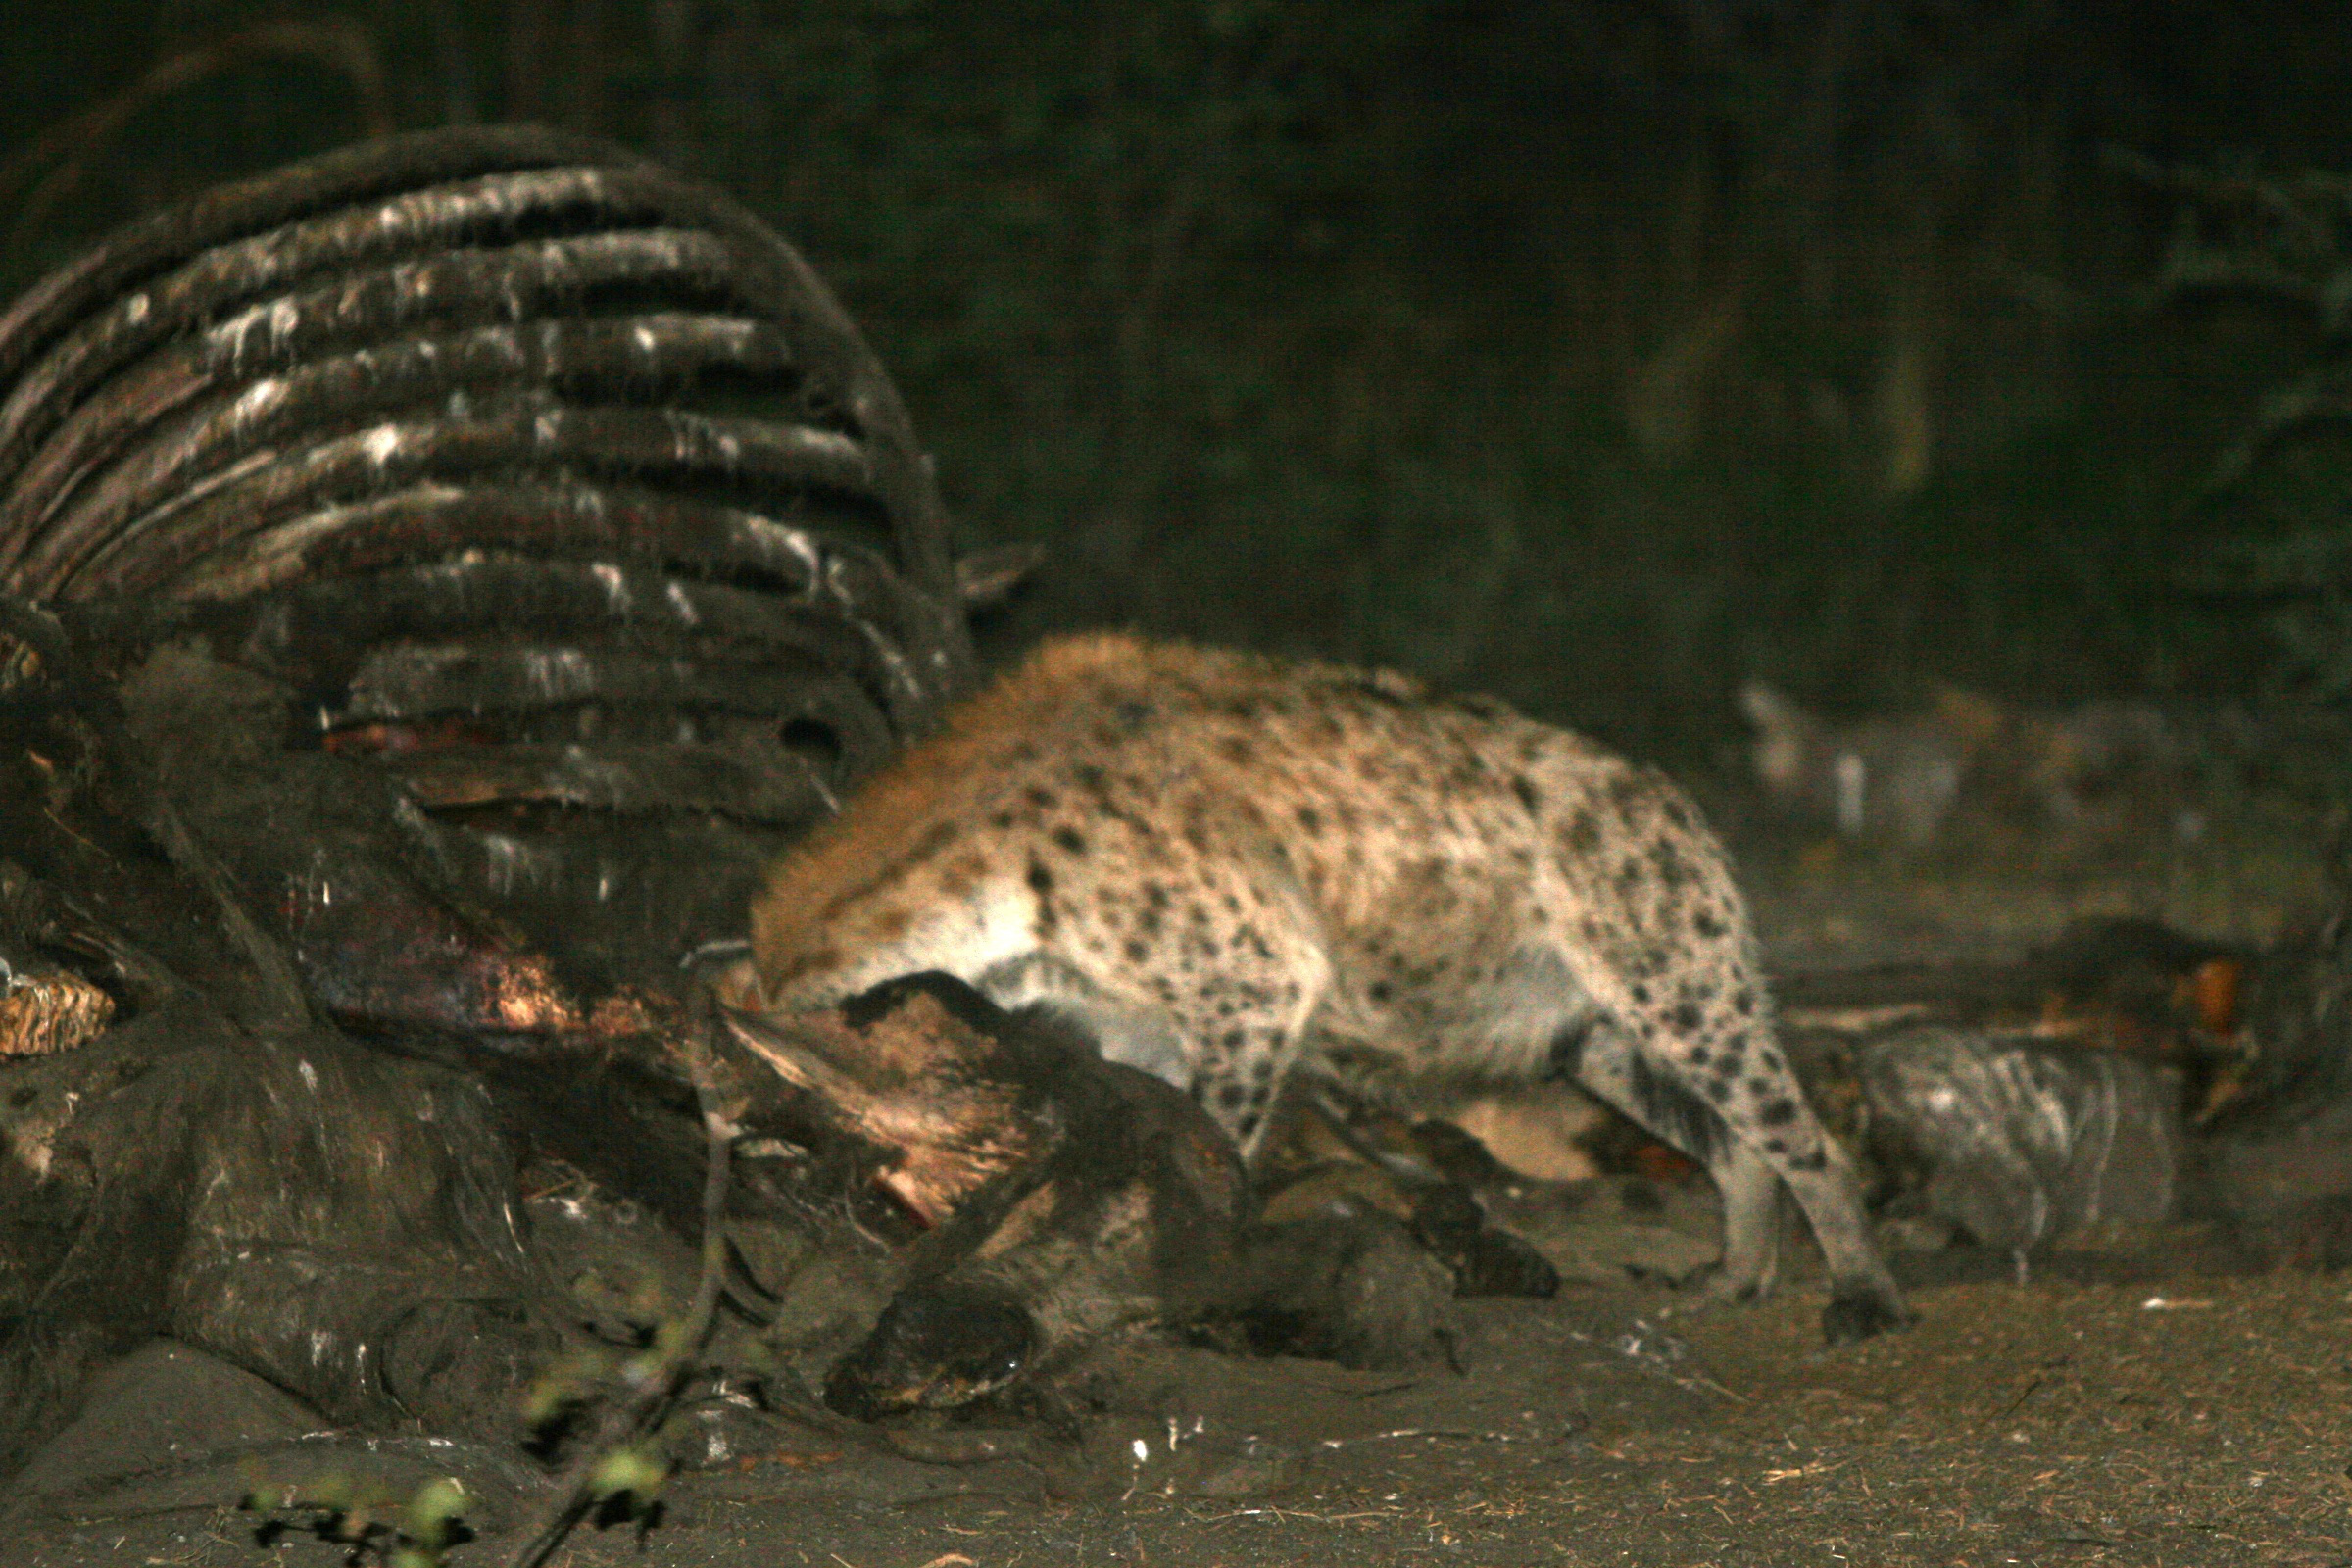

In [9]:
def predict(image, pipeline, threshold=0.7, verbose=False):
    results = pipeline(image)
    if verbose:
        print(results)
    return plot_results(image, results, threshold)


# Let's test for another test image
iter_temp = iter(val_ds)
img = next(iter_temp)["image"]
predict(img, obj_detector, verbose=True)

In [ ]:
from tqdm.auto import tqdm


def plot_images(dataset, indices, verbose=False):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = predict(dataset[idx]["image"], obj_detector, verbose=verbose)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()
    
def plot_images_iterable(dataset, indices, verbose=False):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    
    ds_iter = iter(dataset)
    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = predict(next(ds_iter)["image"], obj_detector, verbose=verbose)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# plot_images(wildlife_ds, range(6), verbose=True)
plot_images_iterable(wildlife_ds, range(6), verbose=True)

In [ ]:
def load_images_from_folder(folder, batch_size, max_images=None):
    images = []
    filenames = sorted(os.listdir(folder))  # Sort to maintain order
    count = 0  # Keep track of the number of images loaded

    for filename in filenames:
        if max_images and count >= max_images:
            break

        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append((img, filename))
            count += 1

        if len(images) == batch_size:  # Return a batch when size is reached
            yield images
            images = []  # Reset for next batch

    if images:  # Yield remaining images if any
        yield images

In [ ]:
def plot_process_folder(folder, batch_size=5, max_images=None, verbose=False):
    """
    Process a folder of images in batches, with an optional limit on the number of images.

    Args:
        folder (str): Path to the folder containing images.
        batch_size (int): Number of images to process in each batch.
        max_images (int, optional): Maximum number of images to load. If None, all images are loaded.
    """
    for batch in load_images_from_folder(folder, batch_size, max_images):
        original_images, filenames = zip(*batch)
        num_rows = batch_size // 3
        num_cols = 3
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

        for i in tqdm(range(batch_size)):
            row = i // num_cols
            col = i % num_cols

            # Draw image

            image = original_images[i]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(image)
            image = image.convert("RGB")
            
            image = predict(image, obj_detector, verbose=verbose)

            # print(f"axes: {axes}")

            # Display image on the corresponding subplot
            axes[row, col].imshow(image)
            axes[row, col].axis("off")

        plt.tight_layout()
        plt.show()
        

In [ ]:
max_images_to_process = 9
folder_path = Path.cwd().resolve().parent / "data/hyena_separated/dark"
print(folder_path)
plot_process_folder(folder_path, batch_size=9, max_images=max_images_to_process, verbose=True)  # Adjust batch size as needed